This homework is based off a notebook. 
1. You will alter this as need for your results / questions. 
2. When you've successfully run them on a colab, download as an .ipynb and submit on the LMS.

Make certain you are on a GPU Runtime first, by going to Runtime and selecting "Change Runtime Type", and then choosing Hardware Accelerator as GPU.

In this homework, you will build an emotion classifier based on a Huggingface emotions dataset.

You will need to install 🤗 Transformers, numpy and 🤗 Datasets. Run the following three cells.

In [2]:
pip install torch torchvision

In [3]:
pip install optuna

     |████████████████████████████████| 296kB 17.2MB/s 
     |████████████████████████████████| 163kB 55.4MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 112kB 24.4MB/s 
     |████████████████████████████████| 143kB 41.5MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=3582849eb12df4c4a062e88be0ce5ccf30251b15ca56b62bab3fccec3b0be2fa
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [4]:
pip install sklearn

In [5]:
pip install datasets==1.3.0

     |████████████████████████████████| 184kB 17.7MB/s 
     |████████████████████████████████| 245kB 42.9MB/s 
     |████████████████████████████████| 112kB 54.4MB/s 


In [6]:
pip install transformers

     |████████████████████████████████| 2.0MB 17.3MB/s 
     |████████████████████████████████| 3.2MB 48.8MB/s 
     |████████████████████████████████| 890kB 44.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=35f905b87c55161b6a1f2a1b85bdbab6cac52783a3a1155c60633df205d26754
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
pip install numpy==1.20.1

     |████████████████████████████████| 15.3MB 194kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: optuna 2.6.0 has requirement numpy<1.20.0, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [8]:
from datasets import load_dataset
emotions_dataset = load_dataset('go_emotions', 'simplified')
print(emotions_dataset['train']['labels'])

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e. Subsequent calls will reuse this data.
[[27], [27], [2], [14], [3], [26], [15], [8, 20], [0], [27], [6], [1, 4], [27], [5], [3], [3, 12], [15], [2], [27], [6, 22], [6, 9, 27], [12], [27], [27], [27], [2], [27], [16, 25], [15], [27], [2], [6], [27], [2, 7], [6], [17], [27], [0], [25], [27], [0, 15], [15, 18], [16, 27], [27], [7, 13], [10], [20], [27], [27], [27], [27], [27], [4], [27], [13, 15], [10], [27], [27], [27], [15], [0, 1], [12], [27], [13], [27], [0, 15], [27], [1], [27], [0], [27], [0, 5], [3], [27], [27], [27], [0, 13, 15], [0], [27], [1], [13], [4], [25], [4], [27], [25], [0, 15], [9], [4, 22], [27], [4], [27], [24], [18], [4], [27], [7], [27], [7], [27], [0], [3], [10], [27], [27], [5], [27], [6, 7], [27], [15], [27], [0], [22], [27], [17], [27], [2], [2], [27], [27], [9, 27], [4, 5], [27], [3], [2, 

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [9]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
  

In [10]:
# For simplicity, train model with single label for item.
restricted_dataset = emotions_dataset.filter(lambda x: len(x["labels"]) == 1 and 27 not in x['labels'])
print(len(restricted_dataset['train']))
show_random_elements(restricted_dataset['train'])


23485


,id,labels,text
0,edvsznx,[12],You have been banned from the mickey mouse clubhouse for inappropriate behavior
1,eebqebz,[0],These Red Dead Redemption graphics are amazing
2,eehqdwn,[22],"I know that, but it just reminds me of darkest dungeon too"
3,eeu21sd,[22],History was written by the victors. Now we have history witten by the real truth agreed upon the everybody on the network
4,edf0xso,[20],They didn’t take it; you abandoned it. A TSA agent clarified that for me once. I hope you can replace it easily.
5,eezigzy,[7],Only 5 more years to go. Can’t wait!
6,edeql27,[11],"Lmao ""guys I was *coerced* into sending her a picture of my junk"". That just sounds dumb as hell"
7,eejyt9m,[25],im still starving
8,ef9u2jy,[9],"The fact that this podcast isn't called ""Z-Targeting Dio's Balls"" disappoints me greatly."
9,eetns9i,[4],"Ok 🤷‍♀️ I believe in you, you can do it."



The emotions are provided as numeric labels. These are the actual orderings, beginning at 0 for admiration:

In [11]:
labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", 
          "confusion", "curiosity", "desire", "disappointment", "disapproval",
          "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
          "joy", "love", "nervousness", "optimism", "pride", "realization",
          "relief", "remorse", "sadness", "surprise", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}

index_to_labels  

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [12]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer,DistilBertTokenizerFast,DistilBertModel

model_name = 'distilbert-base-uncased'
model_init= DistilBertModel.from_pretrained(model_name, num_labels=27)
#config = AutoConfig.from_pretrained(model_name, num_labels=27)
#model = AutoModelForSequenceClassification.from_pretrained(config)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model_init.save_pretrained("/distilbert-base-uncased")
tokenizer.save_pretrained("/distilbert-base-uncased")

('/distilbert-base-uncased/tokenizer_config.json',
 '/distilbert-base-uncased/special_tokens_map.json',
 '/distilbert-base-uncased/vocab.txt',
 '/distilbert-base-uncased/added_tokens.json')

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example

encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.map(convert_labels_to_int)
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'id', 'input_ids', 'labels', 'text'],
        num_rows: 23485
    })
    validation: Dataset({
        features: ['attention_mask', 'id', 'input_ids', 'labels', 'text'],
        num_rows: 2956
    })
    test: Dataset({
        features: ['attention_mask', 'id', 'input_ids', 'labels', 'text'],
        num_rows: 2984
    })
})

## Fine-tuning the model

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
from transformers import Trainer, TrainingArguments
metric_name = "accuracy"

args = TrainingArguments(
    "test-emotions",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

args_1=TrainingArguments(
    "test-emotion-1",
    evaluation_strategy="epoch",
    learning_rate=2e5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

In [ ]:
metric = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:

validation_key = "validation"
trainer = Trainer(
    model_init,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer_1=Trainer(
    model_init,
    args_1,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [ ]:
import numpy as np
trainer_1.train()
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,nan,0.110284,2.668300,1107.811000
2,No log,nan,0.110284,2.680700,1102.689000
3,nan,nan,0.110284,2.685500,1100.729000
4,nan,nan,0.110284,2.672800,1105.958000
5,nan,nan,0.110284,2.682000,1102.170000


TrainOutput(global_step=920, training_loss=nan, metrics={'train_runtime': 357.1304, 'train_samples_per_second': 2.576, 'total_flos': 1858364638796160.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 1660042, 'init_mem_gpu_alloc_delta': 538964992, 'init_mem_cpu_peaked_delta': 67054, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 498278, 'train_mem_gpu_alloc_delta': 824953344, 'train_mem_cpu_peaked_delta': 94111589, 'train_mem_gpu_peaked_delta': 3894387712})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one). We also run a sample prediction to demonstrate the API:

In [ ]:
trainer.evaluate()
trainer_1.evaluate()

{'epoch': 5.0,
 'eval_accuracy': 0.11028416779431664,
 'eval_loss': nan,
 'eval_mem_cpu_alloc_delta': 402903,
 'eval_mem_cpu_peaked_delta': 164368,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 196978176,
 'eval_runtime': 2.6952,
 'eval_samples_per_second': 1096.753}

In [ ]:
prepared_input = tokenizer.prepare_seq2seq_batch(["I am very sad"], return_tensors='pt')
model_init = model_init.to('cpu')
model_init.eval()
model_output = model_init(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
index_to_labels[prediction]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


'admiration'

# Your work

# New Section

Qs 1. Can you report how accuracy changes with varying the hypyerparameters defined above? How does accuracy change with increasing number of epochs? Learning rate? Mention your final choice of parameters and graph how they impact accuracy. 

Qs 2. Try any 2 other models for sequence classification supported by Huggingface and repeat Qs 1 for these. You can find a full list of these [here](https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification). (For those of you working with text for your project, you may also find several other useful models for Seq2Seq modeling, question answering, etc.)

Qs 3. Wrangle / change the data so that you can instead build a "positive" emotion vs "negative" emotions classifier, by combining labels. For any emotions that you feel are too neutral, you may drop them from evaluation. Can you now report the accuracy of a classifer on this data? You may use one of the model architectures from (1) or (2)

Qs 4. Export models from qs 1 and 3, and build a FastAPI around it, as discussed in class, which returns the most likely emotion found. (You may need to look up Huggingface documentation on how to save and load models). In particular, you should support two API endpoints - "detect_emotion_binary" and "detect_emotion_full" which supports each model.

Qs 5. Finally, can you dockerize this? You do NOT need to deploy this to the cloud.

Submission instructions: Zip your compiled .ipynb notebook, your fast_api code and your dockerfile, and submit to LMS as one file. You should confirm that your .ipynb can be imported to colab and run in sequence. All your results for Qs 1-3 should be reported in the notebook itself.

In [ ]:
pip install matplotlib

**Answer 1**

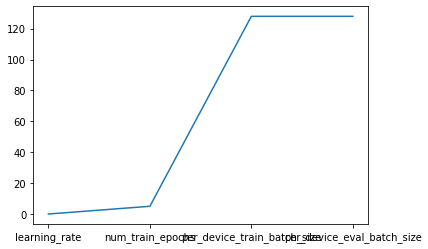

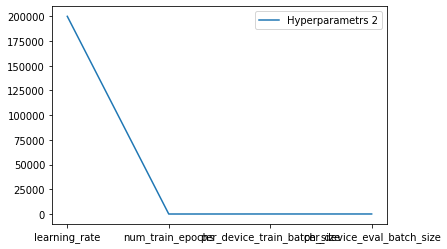

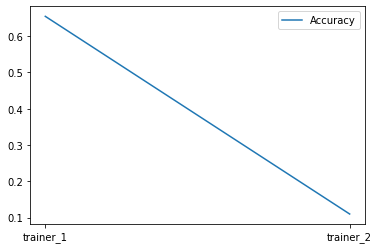

In [ ]:

import matplotlib.pyplot as plt

data = {'learning_rate': 2e-5, 'num_train_epochs': 5, 'per_device_train_batch_size': 128, 'per_device_eval_batch_size': 128}
names = list(data.keys())
values = list(data.values())
data_1 = {'learning_rate': 2e5, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}
names_1 = list(data_1.keys())
values_1 = list(data_1.values())
data_2 = {'trainer_1': 0.6546008119079838, 'trainer_2': 0.11028416779431664}
names_2 = list(data_2.keys())
values_2 = list(data_2.values())

fig, axs = plt.subplots()
axs.plot(names, values,label="Hyperparametrs 1")


fig_1, ax_1 = plt.subplots()
ax_1.plot(names_1, values_1, label="Hyperparametrs 2")
ax_1.legend()

fig_2, ax_2 = plt.subplots()
ax_2.plot(names_2, values_2, label="Accuracy")
ax_2.legend()

plt.show()

**Answer 2**

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

model_name_1 = 'bert-base-uncased'
model_init_1= AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=27)

tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1)

ModuleNotFoundError: ignored

In [ ]:
def preprocess_function(examples):
    return tokenizer_1(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example

encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.map(convert_labels_to_int)

In [ ]:
from transformers import Trainer, TrainingArguments
metric_name = "accuracy"

args_2 = TrainingArguments(
    "test-emotions_2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

args_3=TrainingArguments(
    "test-emotion-3",
    evaluation_strategy="epoch",
    learning_rate=2e5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [ ]:
metric_1 = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric_1.compute(predictions=predictions, references=labels)

In [ ]:
validation_key = "validation"
trainer_2 = Trainer(
    model_init_1,
    args_2,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer_3=Trainer(
    model_init_1,
    args_3,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
import numpy as np
trainer_2.train()
trainer_3.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,1.585149,0.595061,3.434400,860.695000
2,No log,1.357798,0.639378,3.435400,860.443000
3,1.706500,1.285453,0.648512,3.431200,861.518000
4,1.706500,1.262066,0.649188,3.438200,859.760000
5,1.706500,1.259544,0.646143,3.446100,857.784000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,nan,nan,0.110284,3.516800,840.541000
2,nan,nan,0.110284,3.509800,842.222000


TrainOutput(global_step=1468, training_loss=nan, metrics={'train_runtime': 231.2504, 'train_samples_per_second': 6.348, 'total_flos': 1106953154978652.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 51886, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 950364, 'train_mem_gpu_alloc_delta': 1331038208, 'train_mem_cpu_peaked_delta': 94288028, 'train_mem_gpu_peaked_delta': 1629847040})

In [ ]:
trainer_2.evaluate()
trainer_3.evaluate()

{'epoch': 2.0,
 'eval_accuracy': 0.11028416779431664,
 'eval_loss': nan,
 'eval_mem_cpu_alloc_delta': 405456,
 'eval_mem_cpu_peaked_delta': 207138,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 49843712,
 'eval_runtime': 3.5229,
 'eval_samples_per_second': 839.083}

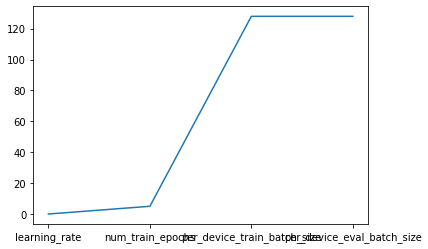

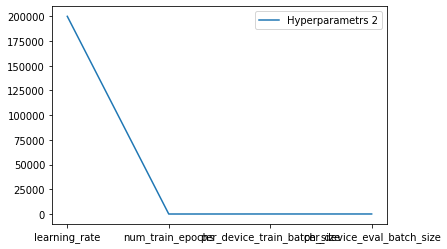

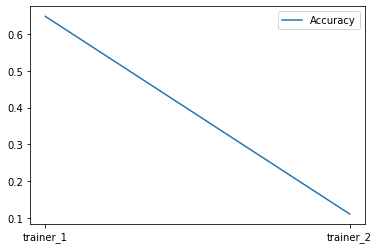

In [ ]:

import matplotlib.pyplot as plt

data = {'learning_rate': 2e-5, 'num_train_epochs': 5, 'per_device_train_batch_size': 128, 'per_device_eval_batch_size': 128}
names = list(data.keys())
values = list(data.values())
data_1 = {'learning_rate': 2e5, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32}
names_1 = list(data_1.keys())
values_1 = list(data_1.values())
data_2 = {'trainer_1': 0.6491880920162382, 'trainer_2': 0.11028416779431664}
names_2 = list(data_2.keys())
values_2 = list(data_2.values())

fig, axs = plt.subplots()
axs.plot(names, values,label="Hyperparametrs 1")


fig_1, ax_1 = plt.subplots()
ax_1.plot(names_1, values_1, label="Hyperparametrs 2")
ax_1.legend()

fig_2, ax_2 = plt.subplots()
ax_2.plot(names_2, values_2, label="Accuracy")
ax_2.legend()

plt.show()

**Answer 3**

In [ ]:
labels = ["positive", "positive", "negative", "negative", "positive", "positive", 
          "negative", "neutral", "positive", "negative", "negative",
          "negative", "neutral", "positive", "negative", "positive", "negative",
          "positive", "positive", "neutral", "positive", "neutral", "neutral",
          "positive", "negative", "negative", "neutral", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}

index_to_labels 

{0: 'positive',
 1: 'positive',
 2: 'negative',
 3: 'negative',
 4: 'positive',
 5: 'positive',
 6: 'negative',
 7: 'neutral',
 8: 'positive',
 9: 'negative',
 10: 'negative',
 11: 'negative',
 12: 'neutral',
 13: 'positive',
 14: 'negative',
 15: 'positive',
 16: 'negative',
 17: 'positive',
 18: 'positive',
 19: 'neutral',
 20: 'positive',
 21: 'neutral',
 22: 'neutral',
 23: 'positive',
 24: 'negative',
 25: 'negative',
 26: 'neutral',
 27: 'neutral'}

In [ ]:
prepared_input = tokenizer.prepare_seq2seq_batch(["I am very sad"], return_tensors='pt')
model_init = model_init.to('cpu')
model_init.eval()
model_output = model_init(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
index_to_labels[prediction]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


'positive'

In [1]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,456 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160980 files and directories c

In [4]:
!transformers-cli login

2021-03-20 09:52:30.333326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: sarim
Password: 
Login successful
Your token: eolCFqlkoNiCtCaYKvoKOPVbmVdsDPluNgqQMJBpaFsLecgIVOmEiVhZKtXTcCyEBHXXGpwoUrbBvEHMNMqQBeYvLcoGVWTybKPIgfudEgDXekfsuKZnUiBZTyJYwSNk 

Your token has been saved to /root/.huggingface/token


In [6]:
!git clone https://huggingface.co/sarim/myModel

Cloning into 'myModel'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (3/3), done.


In [8]:
!cd myModel

In [9]:
!git config --global user.email "sarimk80@gmail.com"

In [10]:
!git config --global user.name "sarim khan"

In [13]:
!git init
!git add .


Initialized empty Git repository in /content/.git/
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> myModel
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached myModel
hint: 
hint: See "git help submodule" for more information.


In [17]:
!git commit -m "Initial commit"
!git push --set-upstream master master

On branch master
nothing to commit, working tree clean
fatal: 'master' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [18]:
!ls

myModel  sample_data


In [19]:
!cd

In [20]:
!ls

myModel  sample_data
